# Libraries

In [6]:
# Import necessary libraries
import os
import warnings
import pickle
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow import keras
from tensorflow.keras.utils import image_dataset_from_directory
from tensorflow.keras.layers import Rescaling
from sklearn.metrics import precision_score, accuracy_score, recall_score

# Suppress TensorFlow warnings
warnings.filterwarnings("ignore")
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'  # Suppress TensorFlow logs

# Set random seeds for reproducibility
np.random.seed(0)
tf.compat.v1.set_random_seed(0)  # Set random seed for TensorFlow


# Parameters & Loading Data

In [7]:
# Set batch size for loading the dataset
batch_size = 128

# Load the training and validation datasets
train_gen = image_dataset_from_directory(
    directory="dataset/train",
    image_size=(256, 256),
    batch_size=batch_size
)

test_gen = image_dataset_from_directory(
    directory="dataset/valid",
    image_size=(256, 256),
    batch_size=batch_size
)

# Extract class names from the training data
class_names = train_gen.class_names
print("Class names:", class_names)

# Apply rescaling to the images (normalize pixel values to the range [0, 1])
rescale = Rescaling(scale=1.0 / 255)

# Apply the rescaling transformation to the datasets
train_gen = train_gen.map(lambda image, label: (rescale(image), label), num_parallel_calls=tf.data.AUTOTUNE)
test_gen = test_gen.map(lambda image, label: (rescale(image), label), num_parallel_calls=tf.data.AUTOTUNE)

# Print the number of class names
print("Number of classes:", len(class_names))

# Save class names to a pickle file for later use
pickle_file_path = r'class_names.pkl'
with open(pickle_file_path, 'wb') as f:
    pickle.dump(class_names, f)

# Confirm the class names have been saved
print(f'Class names saved to {pickle_file_path}')


Found 17410 files belonging to 9 classes.
Found 4353 files belonging to 9 classes.
Class names: ['Apple___Apple_scab', 'Apple___Black_rot', 'Apple___healthy', 'Potato___Early_blight', 'Potato___Late_blight', 'Potato___healthy', 'Tomato___Early_blight', 'Tomato___Late_blight', 'Tomato___healthy']
Number of classes: 9
Class names saved to class_names.pkl


# Model Layers & Training

In [8]:
# Initialize a Sequential model
model = keras.Sequential()

# First block: Reduce the number of filters or layers to minimize complexity
model.add(keras.layers.Conv2D(32, (3, 3), activation="relu", padding="same", input_shape=(256, 256, 3)))
model.add(keras.layers.Conv2D(32, (3, 3), activation="relu", padding="same"))
model.add(keras.layers.MaxPooling2D(2, 2))  # Reduce pooling size to minimize spatial dimensions

# Second block: Reduce redundancy in the architecture
model.add(keras.layers.Conv2D(64, (3, 3), activation="relu", padding="same"))
model.add(keras.layers.Conv2D(64, (3, 3), activation="relu", padding="same"))
model.add(keras.layers.MaxPooling2D(2, 2))  # Same pooling size as the previous block

# Third block: Decrease the number of filters to reduce complexity further
model.add(keras.layers.Conv2D(128, (3, 3), activation="relu", padding="same"))
model.add(keras.layers.Conv2D(128, (3, 3), activation="relu", padding="same"))
model.add(keras.layers.MaxPooling2D(2, 2))  # Maintain consistency in pooling size

# Flatten the output and add fully connected layers (Dense layers)
model.add(tf.keras.layers.Flatten())
model.add(keras.layers.Dense(512, activation="relu"))  # Reduce number of neurons to prevent overfitting
model.add(keras.layers.Dense(512, activation="relu"))  # Reduce number of neurons to prevent overfitting
model.add(keras.layers.Dropout(0.5))  # Dropout for regularization

# Output layer: Number of neurons corresponds to the number of classes
model.add(keras.layers.Dense(len(class_names), activation="softmax"))

# Define the optimizer and compile the model
opt = keras.optimizers.Adam(learning_rate=0.0001)
model.compile(optimizer=opt, loss="sparse_categorical_crossentropy", metrics=['accuracy'])

# Print the model summary
model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d_6 (Conv2D)                    │ (None, 256, 256, 32)        │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_7 (Conv2D)                    │ (None, 256, 256, 32)        │           9,248 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_3 (MaxPooling2D)       │ (None, 128, 128, 32)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_8 (Conv2D)                    │ (None, 128, 128, 64)        │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_9 (Conv2D)                    │ (None, 128, 128, 64)        │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_4 (MaxPooling2D)       │ (None, 64, 64, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_10 (Conv2D)                   │ (None, 64, 64, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_11 (Conv2D)                   │ (None, 64, 64, 128)         │         147,584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_5 (MaxPooling2D)       │ (None, 32, 32, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_1 (Flatten)                  │ (None, 131072)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 512)                 │      67,109,376 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_4 (Dense)                      │ (None, 512)                 │         262,656 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 512)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_5 (Dense)                      │ (None, 9)                   │           4,617 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 67,663,657 (258.12 MB)

 Trainable params: 67,663,657 (258.12 MB)

 Non-trainable params: 0 (0.00 B)

In [9]:
# Set number of epochs
ep = 5

# Train the model
history = model.fit(
    train_gen,
    validation_data=test_gen,
    epochs=ep,
    verbose=1,  # Option to display training progress (1 = progress bar)
)


model.save("model.keras")
print("model saved")

Epoch 1/5
137/137 ━━━━━━━━━━━━━━━━━━━━ 1106s 8s/step - accuracy: 0.3328 - loss: 1.7894 - val_accuracy: 0.6536 - val_loss: 0.9766
Epoch 2/5
137/137 ━━━━━━━━━━━━━━━━━━━━ 1033s 8s/step - accuracy: 0.7026 - loss: 0.8711 - val_accuracy: 0.8426 - val_loss: 0.4701
Epoch 3/5
137/137 ━━━━━━━━━━━━━━━━━━━━ 1049s 8s/step - accuracy: 0.8378 - loss: 0.4712 - val_accuracy: 0.8863 - val_loss: 0.3309
Epoch 4/5
137/137 ━━━━━━━━━━━━━━━━━━━━ 1029s 8s/step - accuracy: 0.8897 - loss: 0.3266 - val_accuracy: 0.9021 - val_loss: 0.2845
Epoch 5/5
137/137 ━━━━━━━━━━━━━━━━━━━━ 1036s 8s/step - accuracy: 0.9106 - loss: 0.2608 - val_accuracy: 0.9201 - val_loss: 0.2330
model saved


# EVALUATION

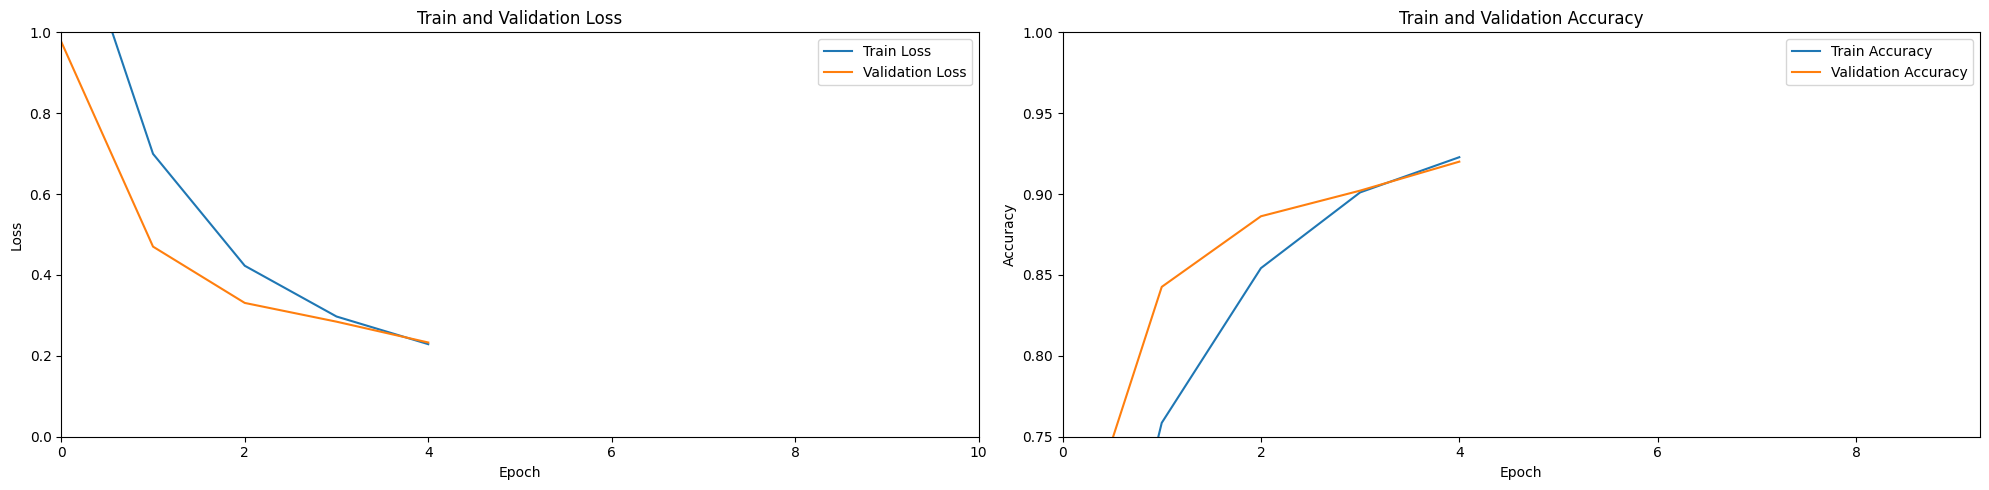

In [12]:
# Plotting the training and validation loss and accuracy
plt.figure(figsize=(20, 5))

# Subplot 1: Train and Validation Loss
plt.subplot(1, 2, 1)
plt.title("Train and Validation Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.plot(history.history['loss'], label="Train Loss")
plt.plot(history.history['val_loss'], label="Validation Loss")
plt.xlim(0, 10)  # Set x-axis limits
plt.ylim(0.0, 1.0)  # Set y-axis limits
plt.legend()  # Add legend

# Subplot 2: Train and Validation Accuracy
plt.subplot(1, 2, 2)
plt.title("Train and Validation Accuracy")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.plot(history.history['accuracy'], label="Train Accuracy")
plt.plot(history.history['val_accuracy'], label="Validation Accuracy")
plt.xlim(0, 9.25)  # Set x-axis limits
plt.ylim(0.75, 1.0)  # Set y-axis limits
plt.legend()  # Add legend

# Adjust layout for better spacing
plt.tight_layout()

In [13]:
# Initialize empty lists to store labels and predictions
labels = []
predictions = []

# Loop through the test data generator
for x, y in test_gen:
    # Append the true labels (y) to the labels list
    labels.append(list(y.numpy()))
    
    # Predict the labels and append to the predictions list
    pred = model.predict(x)  # Get the model predictions
    predictions.append(tf.argmax(pred, axis=1).numpy())  # Get the predicted class labels

# Flatten the lists using itertools.chain
predictions = list(itertools.chain.from_iterable(predictions))
labels = list(itertools.chain.from_iterable(labels))

# Print training accuracy and test accuracy
train_accuracy = history.history['accuracy'][-1] * 100
test_accuracy = accuracy_score(labels, predictions) * 100

# Display the results
print("Train Accuracy  : {:.2f} %".format(train_accuracy))
print("Test Accuracy   : {:.2f} %".format(test_accuracy))

4/4 ━━━━━━━━━━━━━━━━━━━━ 2s 438ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 2s 385ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 2s 400ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 345ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 2s 374ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 2s 390ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 360ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 352ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 349ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 2s 388ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 2s 402ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 353ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 351ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 2s 384ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 2s 393ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 2s 382ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 2s 386ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 2s 379ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 2s 409ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 2s 390ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 2s 412ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 2s 441ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 2s 393ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 2s 387ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 2s 384ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 